In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)  #입력 이미지 모양 28 x 28 x 1 Grayscale

z_dim = 100 # latent vector

In [3]:
def build_generator(img_shape , z_dim):  # generator 생성
    model = Sequential()  #model 골격
    
    model.add(Dense(128,input_dim = z_dim)) #1번층 / 128cells & input -> 100 , input_length % input_shape 사용가능
    model.add(LeakyReLU(alpha=0.01)) #활성함수
    model.add(Dense(28*28*1 , activation = 'tanh')) #2번층 / 28*28 , 하이퍼볼릭 탄젠트 사용 ( 1차원 이미지로 재구성)
    model.add(Reshape(img_shape)) # 출력을 3차원으로 재구성 ( 이미지 / Grayscale)
    return model

In [4]:
def build_discriminator(img_shape):  # 판별자 생성
    model = Sequential()
    
    model.add(Flatten(input_shape = img_shape))  # 입력 이미지 1차원으로 펼치기 / 28* 28 * 1과 동일
    model.add(Dense(128)) #128개의 cells
    model.add(LeakyReLU(alpha = 0.01)) # 활성함수
    model.add(Dense(1,activation = 'sigmoid')) #1개의 cell로 sigmoid를 통해 확률 계산
    return model

In [5]:
def build_gan(generator, discriminator): #generator와 discriminator를 합쳐 gan 구성
    
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
discriminator = build_discriminator(img_shape) # 판별자 생성
discriminator.compile(loss = 'binary_crossentropy', optimizer=Adam() , metrics = ['accuracy']) # 판별자 컴파일( 환경설정)

generator = build_generator(img_shape, z_dim) # 생성자 생성

discriminator.trainable = False # 판별자의 가중치를 고정 -> 생성자와의 가중치가 종속이기 떄문 / 판별자는 독립된 컴파일로 훈련

gan = build_gan(generator, discriminator) # gan 생성
gan.compile(loss = 'binary_crossentropy', optimizer= Adam()) #gan 환경설정

In [55]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size , sample_interval): #fit method 구성
    
   
    (x_train , _) , (_,_) = mnist.load_data() #훈련데이터만 존재하면 가능
    
    x_train = x_train / 127.5 -1.0  #x_train => 0~255 , (  )부분 -> 0~2 , 따라서 -1 ~ 1값 반환
    x_train = np.expand_dims(x_train,axis = 3) #1차원 훈련 데이터를 3차원 ( 28x 28 x 1로 교체)
    
    real = np.ones((batch_size ,1)) #real target = 1        원핫인코딩
    
    fake = np.zeros((batch_size,1)) #fake target = 0
    
    for iteration in range(iterations): #진짜 이미지의 랜덤배치 가져오기
        global z , gen_imgs # 전역변수 오류로 인해 , 지역변수로 선언
        z = np.random.normal(0,1,(batch_size, 100)) # 가짜 이미지 벡터 z 생성 / 정규분포를 따르는 (128,100) size의 z 생성
        gen_imgs = generator.predict(z) #생성자가 생성한 이미지 예측 (random vector)
        
        idx = np.random.randint(0, x_train.shape[0], batch_size) #0~ 60000 사이의 랜덤 배치 생성 (128묶음)
        imgs = x_train[idx] # imgs = 진짜 이미지 배치
        
        z= np.random.normal(0,1,(batch_size , 100)) #가짜 이미지벡터 z
        d_loss_real = discriminator.train_on_batch(imgs,real) # 진짜 이미지를 훈련 / loss 반환
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 가짜 이미지를 훈련 / loss 반환
        
        d_loss , accuracy = 0.5* np.add(d_loss_real , d_loss_fake) # 진짜 / 가짜 로스의 평균 -> 정확도, 손실로 반환 ( 판별자 )
        
        
        
        g_loss = gan.train_on_batch(z , real) # gan을 진짜 이미지로 훈련 / loss 반환
        
        if(iteration +1) % sample_interval == 0:  # 1000번 반복마다 확인
            losses.append((d_loss,g_loss)) # 1000번째 마다 loss 추가
            accuracies.append(100.0 *accuracy) # 1000번째 마다 accuracy 추가
            iteration_checkpoints.append(iteration +1) #1000번째 마다 check point 저장
            
            print("%d [ D 손실: %f , 정확도: %.2f%%] [ G 손실: %f]" %
                 (iteration +1 , d_loss, 100.0*accuracy, g_loss)) # 1000번쨰마다 문자열 출력 ( 확인용 )
            sample_images(generator) # 1000번째마다 생성자의 이미지 출력

In [56]:
def sample_images(generator, image_grid_rows = 4 , image_grid_columns = 4): # 생성자 이미지 출력 method
    
    z= np.random.normal(0,1, (image_grid_rows * image_grid_columns, z_dim)) # 정규분포를 따르는 (16 , 100 ) 배치 생성 / 4 x4 잡음 샘플링
    
    gen_imgs = generator.predict(z) # 4 x 4 이미지 생성
    
    gen_imgs = 0.5* gen_imgs + 0.5 #이미지 픽셀값을 0~1로 스케일 조정
    
    fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize = (4,4),sharey = True,sharex = True) # 서브플랏 설정
    
    cnt = 0 
    for i in range(image_grid_rows): # 이미지 그리드 출력
        for j in range(image_grid_columns):
            axs[i , j].imshow(gen_imgs[cnt,:,:,0], cmap = 'gray')
            axs[i , j].axis('off')
            cnt += 1

1000 [ D 손실: 0.086041 , 정확도: 99.61%] [ G 손실: 2.375495]
2000 [ D 손실: 0.079231 , 정확도: 96.88%] [ G 손실: 5.431941]
3000 [ D 손실: 0.055942 , 정확도: 98.05%] [ G 손실: 5.367342]
4000 [ D 손실: 0.187538 , 정확도: 92.19%] [ G 손실: 4.216695]
5000 [ D 손실: 0.155485 , 정확도: 93.75%] [ G 손실: 4.339352]
6000 [ D 손실: 0.376735 , 정확도: 86.33%] [ G 손실: 3.377677]
7000 [ D 손실: 0.445593 , 정확도: 80.47%] [ G 손실: 3.172888]
8000 [ D 손실: 0.520730 , 정확도: 78.91%] [ G 손실: 3.764993]
9000 [ D 손실: 0.266491 , 정확도: 88.67%] [ G 손실: 4.780777]
10000 [ D 손실: 0.203773 , 정확도: 92.19%] [ G 손실: 4.048295]
11000 [ D 손실: 0.348749 , 정확도: 86.33%] [ G 손실: 3.757228]
12000 [ D 손실: 0.421579 , 정확도: 83.59%] [ G 손실: 3.916415]
13000 [ D 손실: 0.443549 , 정확도: 81.25%] [ G 손실: 2.460161]
14000 [ D 손실: 0.297978 , 정확도: 85.16%] [ G 손실: 3.127836]
15000 [ D 손실: 0.379160 , 정확도: 82.03%] [ G 손실: 2.795298]
16000 [ D 손실: 0.314645 , 정확도: 85.16%] [ G 손실: 2.928804]
17000 [ D 손실: 0.431408 , 정확도: 80.47%] [ G 손실: 2.978595]
18000 [ D 손실: 0.374465 , 정확도: 84.38%] [ G 손실: 2.896632]
1

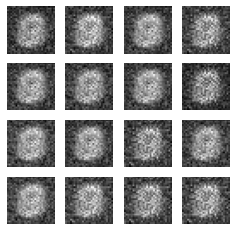

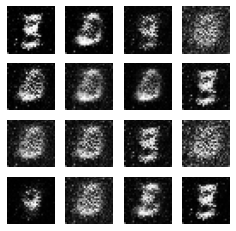

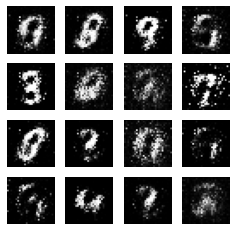

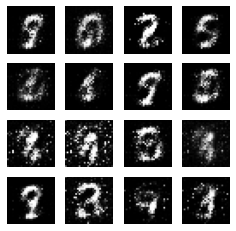

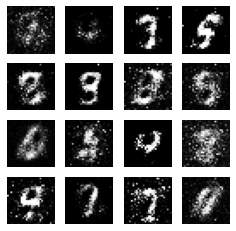

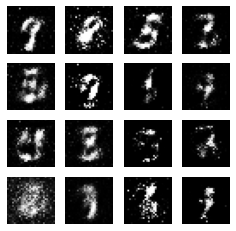

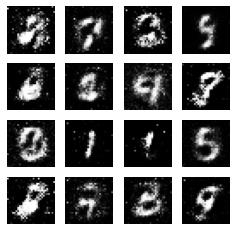

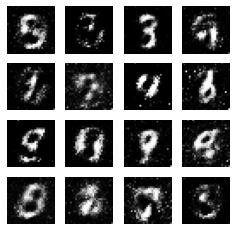

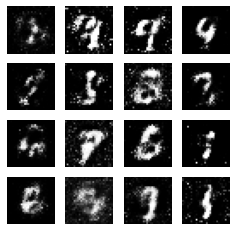

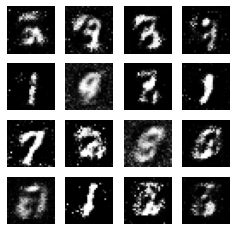

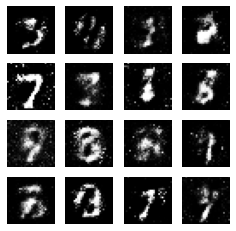

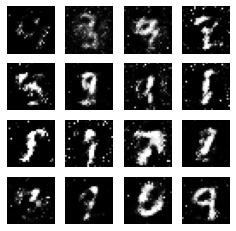

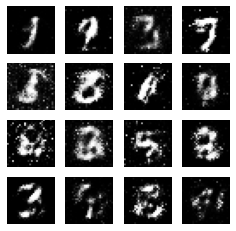

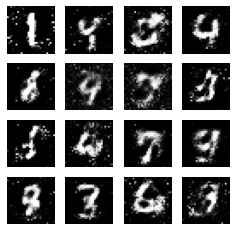

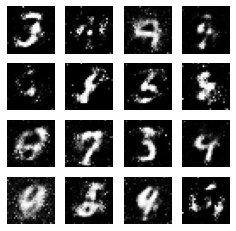

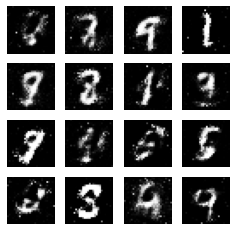

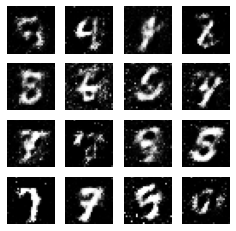

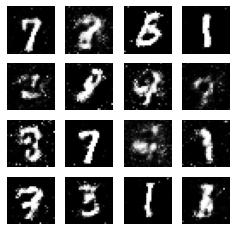

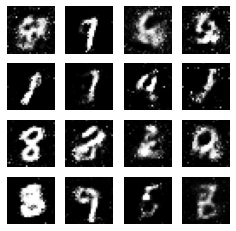

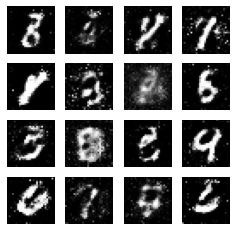

In [57]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations , batch_size , sample_interval)

In [58]:
type(z)

numpy.ndarray

In [59]:
print(z[0])

[ 0.16244216  0.89610601 -0.00433028 -0.85604235  1.47939095 -1.21953441
  0.26780023 -1.46714166  1.1705638  -0.48266751 -0.34853183 -0.70518898
  0.45561508 -0.68362504  0.86726759 -0.67572046  0.05438656 -0.69813859
 -0.63833144  0.39172859  1.09756482  0.26838301  1.4204003   1.39552976
 -0.70306409  0.55997371  0.49678732 -0.98951917  0.77374964  0.20314221
  0.84651438  0.62423508 -0.51139011 -0.44142878 -0.60953941 -0.13295025
  1.49481818  1.61954995 -0.87356303 -0.79690137  0.70505335  1.64288446
  2.10314718  0.40534353  0.40767203 -0.9330921   0.2621696   0.20648684
  2.77154385  1.09152343  0.68578292  0.30441547 -0.57637779 -1.95119505
  1.52026003 -1.09299261 -0.16295605  1.18419725 -0.02843775  1.81184365
 -0.58834691  0.14154574 -0.35063511  0.36369241 -0.71926542 -1.52568923
 -1.07186492  1.62376507  0.53791208 -0.70016038 -0.20812559  1.17107191
 -0.05553409  0.55886435  0.27172178 -0.18398259  1.21217451  0.0914295
 -1.49168117  1.45554864  0.99720929  0.12792027 -0.

In [62]:
print(x_train.shape[0])

NameError: name 'x_train' is not defined